In [4]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
tf.keras.__version__

'2.2.4-tf'

In [6]:
tf.config.gpu.set_per_process_memory_growth(True)
# sess = tf.compat.v1.Session(config = config)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

The following GPU devices are available: /device:GPU:0


## Loading datasets

Data source: https://www.kaggle.com/c/aerial-cactus-identification/data

### Move train set to subdirs for each class

In [7]:
%%bash 
unzip train.zip -d dataset/ > /dev/null 2>&1

In [27]:
train_dir = 'dataset/train/'
cactus_dir = os.path.join(train_dir, 'cactus')
no_cactus_dir = os.path.join(train_dir, 'no_cactus')

if not os.path.exists(cactus_dir):
    os.mkdir(cactus_dir)
    os.mkdir(no_cactus_dir)

labels_map = {0: 'no_cactus', 1: 'cactus'}
train_csv_df = pd.read_csv('dataset/train.csv')
train_csv_df['label'] = train_csv_df.has_cactus.map(labels_map)
train_csv_df['path'] =  train_dir + train_csv_df['label'] + '/' + train_csv_df['id']

train_csv_df.head()

,id,has_cactus,label,path
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1,cactus,dataset/train/cactus/0004be2cfeaba1c0361d39e2b...
1,000c8a36845c0208e833c79c1bffedd1.jpg,1,cactus,dataset/train/cactus/000c8a36845c0208e833c79c1...
2,000d1e9a533f62e55c289303b072733d.jpg,1,cactus,dataset/train/cactus/000d1e9a533f62e55c289303b...
3,0011485b40695e9138e92d0b3fb55128.jpg,1,cactus,dataset/train/cactus/0011485b40695e9138e92d0b3...
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1,cactus,dataset/train/cactus/0014d7a11e90b62848904c141...


In [9]:
train_csv_df.apply(lambda x: os.rename(os.path.join(train_dir, x[0]), x[3]), axis=1);

### Show image

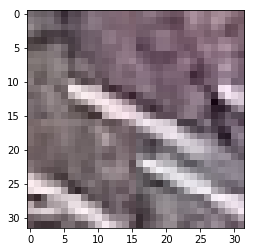

In [10]:
img = tf.keras.preprocessing.image.load_img(train_csv_df.loc[1, 'path'])
x = tf.keras.preprocessing.image.img_to_array(img)
plt.imshow(x/255.)

### Create Image Data Generator

In [11]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255.,
    validation_split=0.1,
    horizontal_flip=True,
    vertical_flip=True,
#     shear_range=0.1,
    brightness_range = (1.0, 1.0)
)

train_gen = train_datagen.flow_from_directory(train_dir, target_size=(32, 32), subset='training', batch_size=32, class_mode='binary')
valid_gen = train_datagen.flow_from_directory(train_dir, target_size=(32, 32), subset='validation', batch_size=32, class_mode='binary')

Found 15751 images belonging to 2 classes.
Found 1749 images belonging to 2 classes.


## Create model

In [12]:
clf = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
clf.compile(optimizer, loss='binary_crossentropy', metrics=['accuracy'])

clf.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0

Setting callbacks

In [13]:
filepath_to_best_model = 'model.h5'

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10),
    tf.keras.callbacks.ModelCheckpoint(filepath=filepath_to_best_model, save_best_only=True)
]

In [27]:
batch_size = 64

history = clf.fit_generator(
    train_gen, 
    steps_per_epoch=int(train_gen.samples/batch_size),
    validation_data=valid_gen,
    validation_steps=int(valid_gen.samples/batch_size),
    epochs=100,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/100
246/246 [==============================] - 7s 29ms/step - loss: 0.2273 - accuracy: 0.9046 - val_loss: 0.1136 - val_accuracy: 0.9653
Epoch 2/100
246/246 [==============================] - 6s 24ms/step - loss: 0.1063 - accuracy: 0.9602 - val_loss: 0.0666 - val_accuracy: 0.9757
Epoch 3/100
246/246 [==============================] - 7s 27ms/step - loss: 0.0903 - accuracy: 0.9657 - val_loss: 0.0610 - val_accuracy: 0.9769
Epoch 4/100
246/246 [==============================] - 6s 26ms/step - loss: 0.0840 - accuracy: 0.9685 - val_loss: 0.0544 - val_accuracy: 0.9803
Epoch 5/100
246/246 [==============================] - 7s 28ms/step - loss: 0.0805 - accuracy: 0.9704 - val_loss: 0.1066 - val_accuracy: 0.9606
Epoch 6/100
246/246 [==============================] - 6s 26ms/step - loss: 0.0745 - accuracy: 0.9731 - val_loss: 0.0463 - val_accuracy: 0.9850
Epoch 7/100
246/246 [==============================] - 7s 27ms/step - loss: 0.0632 - accuracy: 0.9763 - val_loss: 0.0408 - val_accuracy:

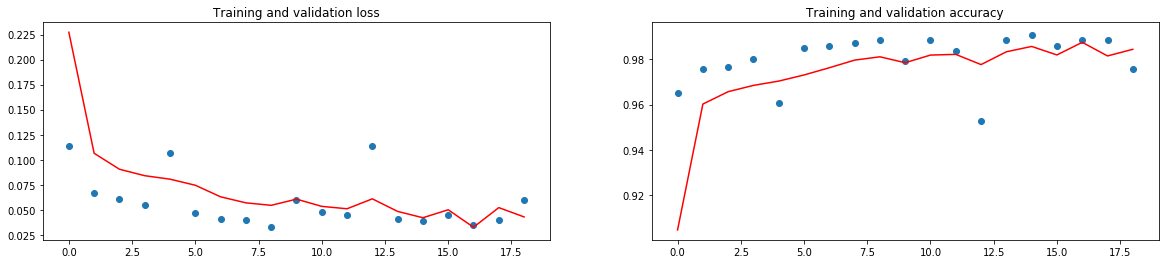

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))
epochs = range(len(history.history['loss']))

axes[0].plot(epochs, history.history['loss'], 'r', label="Training Loss")
axes[0].scatter(epochs, history.history['val_loss'], label="Validation Loss")
axes[0].set_title('Training and validation loss')

axes[1].plot(epochs, history.history['accuracy'], 'r', label="Training Accuracy")
axes[1].scatter(epochs, history.history['val_accuracy'],label="Validation Accuracy")
axes[1].set_title('Training and validation accuracy');

## Loading best model

In [14]:
clf.load_weights('model.h5')

## Visualizing CNN

Creating helper functions.

In [40]:
layers_output = [layer.output for layer in clf.layers]
activation_model = tf.keras.models.Model(inputs=clf.input, outputs=layers_output)

def display_activation(x, activation_model, shape, act_index):
    activations = activation_model.predict(x)
    activation = activations[act_index]
    fig, axes = plt.subplots(nrows=shape[0], ncols=shape[1], figsize=(20, 4))
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        ax.imshow(activation[0, :, :, i], cmap='viridis')
    
    fig.suptitle("layer {}".format(act_index+1))
    plt.plot()

Visualizing layers

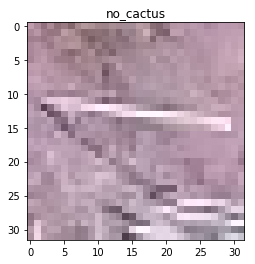

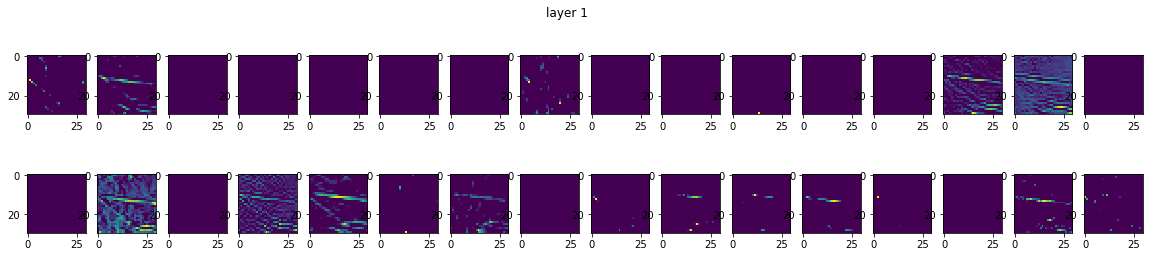

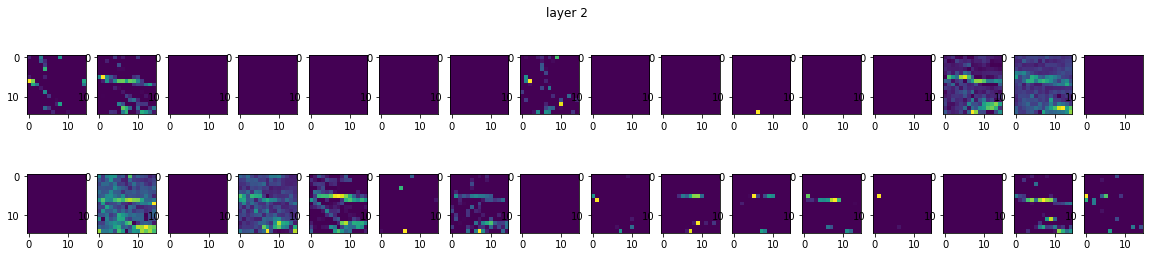

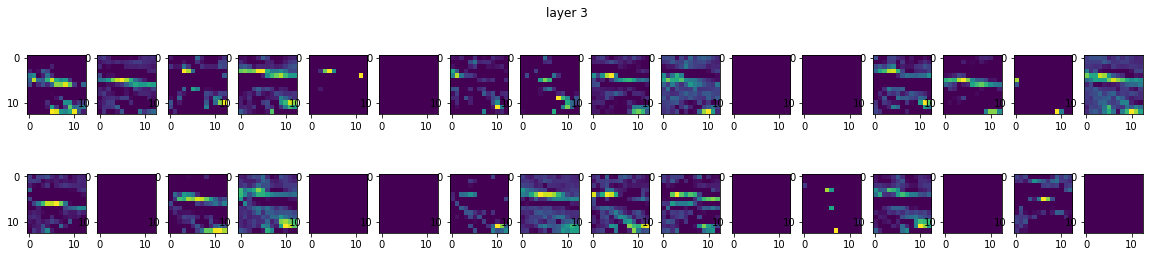

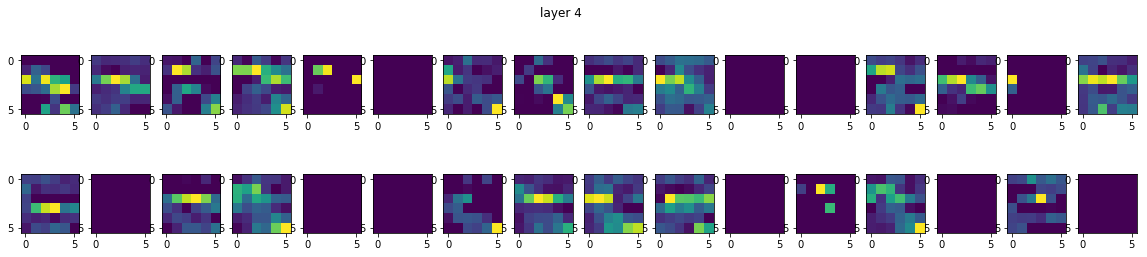

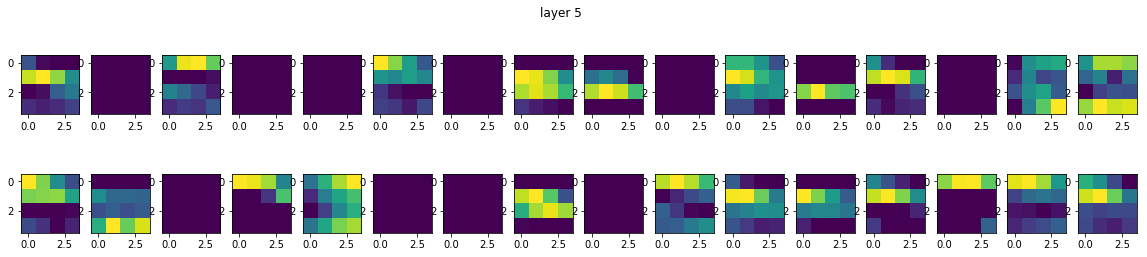

In [54]:
sample = list(next(train_gen))
n = 2
x, y = sample[0][n], sample[1][n]
x = x.reshape(1, 32, 32, 3)

ax = plt.imshow(x.reshape(32, 32, 3))
plt.title(labels_map[y])

for layer_idx in range(0, 5):
    display_activation(x, activation_model, (2, 16), layer_idx)

## Predict

### Unzip testing dataset

In [30]:
%%bash 
unzip test.zip -d dataset/test > /dev/null 2>&1

### Create ImageDataGenerator for testing data

In [31]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)
test_dir = 'dataset/test/'

test_gen = test_datagen.flow_from_directory(test_dir, class_mode=None, target_size=(32, 32), batch_size=64, shuffle=False)

Found 4000 images belonging to 1 classes.


## Predict labels

In [32]:
y_test_pred = clf.predict_generator(test_gen)

In [33]:
sub_df = pd.read_csv('dataset/sample_submission.csv')
sub_df['has_cactus'] = y_test_pred
sub_df.head()

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,0.012973
1,0017242f54ececa4512b4d7937d1e21e.jpg,0.000000
2,001ee6d8564003107853118ab87df407.jpg,0.996750
3,002e175c3c1e060769475f52182583d0.jpg,0.994731
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.010310


In [34]:
sub_df.to_csv('submission.csv', index=False)